# Polarized Cornell Box and polarization viz tools (transient)

## Overview
In this tutorial, you will modify the scene from `0-render_cbox_diffuse.ipynb` to include elements that change polarization of light, and change the `mitransient`/Mitsuba variant so that all the code simulates polarization.

<div class="admonition important alert alert-block alert-warning">

This tutorial assumes that you've read `0-render_cbox_diffuse.ipynb`. Most of the setup code is the same. Here you get to see the polarization of light for that case!

</div>

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>
  
  Use a polarized Mitsuba variant in `mitransient`</li>
  <li>
  
  Modify the scene to include polarizing elements, and to simulate time-resolved polarization</li>
  <li>
  
  Visualize the resulting Stokes vectors</li>
</ul>

</div>

<div class="admonition important alert alert-block alert-warning">

The two tutorials `render_cbox_polarized_and_visualization` and `render_cbox_polarized_and_visualization_steady` are very similar. The first one uses the transient result to generate plots, and the second one uses the steady state image. Look 

</div>

In [1]:
# If you have compiled Mitsuba 3 yourself, you will need to specify the path
# to the compilation folder
# import sys
# sys.path.insert(0, '<mitsuba-path>/mitsuba3/build/python')
import mitsuba as mi
# To set a variant, you need to have set it in the mitsuba.conf file
# https://mitsuba.readthedocs.io/en/latest/src/key_topics/variants.html
mi.set_variant('llvm_ad_mono_polarized')

import mitransient as mitr

print('Using mitsuba version:', mi.__version__)
print('Using mitransient version:', mitr.__version__)

import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
# dr.set_flag(dr.JitFlag.SymbolicScope, False)
# dr.set_flag(dr.JitFlag.SymbolicCalls, False)
# dr.set_flag(dr.JitFlag.SymbolicLoops, False)
# dr.set_flag(dr.JitFlag.SymbolicConditionals, False)

Using mitsuba version: 3.7.0
Using mitransient version: 1.2.0


We use the short alias `mitr` for `mitransient` for improved code readibility.

### Setup the Cornell Box scene

The scene only changes two things:

1. It adds a "gold" material, which changes polarization when light scatters on it:

```diff
+<bsdf type="roughconductor" id="gold">
+  <string name="material" value="Au"/>
+  <string name="distribution" value="ggx"/>
+  <float name="alpha_u" value="0.3"/>
+  <float name="alpha_v" value="0.3"/>
+</bsdf>
```

2. It sets both the big and small boxes of the Cornell Box to that gold material.

```diff
<shape type="obj" id="smallbox">
  <string name="filename" value="meshes/cbox_smallbox.obj"/>
- <ref id="gray"/>
+ <ref id="gold"/>
</shape>
```

You don't need to do anything else! Just using a `polarized` variant will automatically handle all the necessary Stokes vector tracking.

In [2]:
# Load XML file
# You can also use mi.load_dict and pass a Python dict object
# but it is probably much easier for your work to use XML files
import os
scene = mi.load_file(os.path.abspath('cornell-box/cbox_polarized.xml'))

In [3]:
data_steady, data_transient = mi.render(scene, spp=4096)
print(data_steady.shape, data_transient.shape)

(256, 256, 1) (256, 256, 400, 4)


The result is:
1) A steady state image `data_steady` with dimensions (width, height, channels)
2) A transient image `data_transient` with dimensions (width, height, time, channels) where channels represents the $(S_0, S_1, S_2, S_3)$ Stokes' vector components.

### Visualize the steady and transient image
We provide different functions so you can visualize your data in a Jupyter notebook

In [4]:
# Plot the computed steady image
mi.util.convert_to_bitmap(data_steady)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [256, 256],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma, premultiplied alpha
    uint8 G; // @1, normalized, gamma, premultiplied alpha
    uint8 B; // @2, normalized, gamma, premultiplied alpha
  ],
  data = [ 192 KiB of image data ]
]

## Transient-polarization visualization

S1 and S2 share colorbar.

The other plots are those proposed by Wilkie and Weidlich [2013], commonly used in polarization research (see Baek et al. [2020] teaser)

[Wilkie2013] Alexander Wilkie and Andrea Weidlich. 2010. A standardised polarisation visualisation for images. In Proceedings of the 26th Spring Conference on Computer Graphics (SCCG '10). Association for Computing Machinery, New York, NY, USA, 43–50. https://doi.org/10.1145/1925059.1925070

[Baek2020] Seung-Hwan Baek, Tizian Zeltner, Hyun Jin Ku, Inseung Hwang, Xin Tong, Wenzel Jakob, and Min H. Kim. 2020. Image-based acquisition and modeling of polarimetric reflectance. ACM Trans. Graph. 39, 4, Article 139 (August 2020), 14 pages. https://doi.org/10.1145/3386569.3392387

(Plots may take one minute to load)


In [10]:
data_transient_np = np.array(data_transient)
print(f'{data_transient_np.shape=}')
dop = mitr.vis.degree_of_polarization(data_transient_np)
dop, aolp, aolp_scaled, top, chirality = mitr.vis.polarization_generate_false_color(data_transient_np)

data_transient_np.shape=(256, 256, 400, 4)


In [6]:
mitr.vis.show_video_polarized(data_transient_np[:, :, :, :], dop, aolp, top, chirality, save_path='video.mp4', display_method=mitr.vis.DisplayMethod.ShowVideo, show_false_color=True)

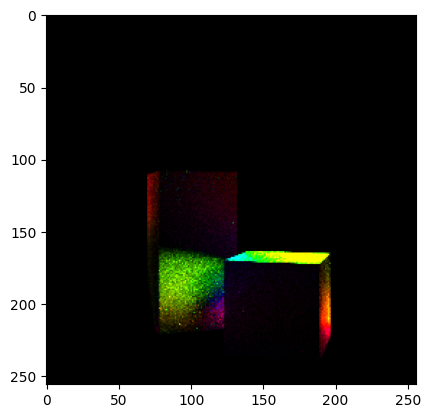

In [15]:
import matplotlib.pyplot as plt

plt.imshow(aolp[..., 120, :])
plt.show()

## Comparison against steady
See the `render_cbox_mirror_steady.ipynb` notebok for comparison against steady polarization rendering.

In [7]:
data_steady_np = data_transient_np.sum(axis=2, keepdims=True)
dop = mitr.vis.degree_of_polarization(data_steady_np)
dop, aolp, aolp_scaled, top, chirality = mitr.vis.polarization_generate_false_color(data_steady_np)
mitr.vis.show_video_polarized(data_steady_np, dop, aolp, top, chirality, save_path='video.mp4', display_method=mitr.vis.DisplayMethod.ShowVideo, show_false_color=True)